In [412]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.utils import shuffle
import time

In [2]:
vid = cv2.VideoCapture("newtrack.h264")

idx = 0
while True:
    _, img = vid.read()
    cv2.imshow('img', img)
    k = cv2.waitKey()
    if k == ord('q'):
        break
    if k == ord('c'):
        fn = "newtrack%d.png" % idx
        cv2.imwrite(fn, img)
        print "wrote", fn    
        idx += 1
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [141]:
train_img = []
train_lab = []

import os
for fname in os.listdir("training"):
    if not fname.endswith("y.png"):
        continue
    basename = "training/" + fname[:-5]
    print basename
    bgr = cv2.imread(basename + ".png")
    yuv = cv2.cvtColor(bgr, cv2.COLOR_BGR2YUV)
    yuv = (yuv.astype(np.float32) - 128.0) / 128.0
    imw = cv2.imread(basename + "w.png", cv2.IMREAD_UNCHANGED)[:, :, 3]
    imy = cv2.imread(basename + "y.png", cv2.IMREAD_UNCHANGED)
    if imy.shape[2] == 4:
        imy = imy[:, :, 3]
    else:
        imy = 255 * np.ones(imy.shape[:2])
    lab = np.zeros((480, 640, 3), np.float32)
    lab[:, :, 0] = (255 - imw) / 255.0
    lab[:, :, 1] = (255 - imy) / 255.0
    lab[:, :, 2] = 1.0 - lab[:, :, 0] - lab[:, :, 1]
    #plt.imshow(lab)
    #plt.show()
    # only take the bottom of the image (below the horizon; the camera is
    # slightly tilted down so it's above the center)
    train_img.append(yuv[210:])
    train_lab.append(lab[210:])
    # also reverse the image
    train_img.append(yuv[210:,::-1])
    train_lab.append(lab[210:,::-1])

print len(train_img)

training/f0020
training/f0047
training/f0074
training/f0101
training/f0128
training/f0155
training/f0182
training/f0209
training/f0236
training/f0263
training/f0560
training/f0830
training/f0857
training/f0884
training/f0911
training/f0965
training/f1073
training/f1127
training/f1343
training/newtrack3
training/newtrack9
42


In [262]:
nfilters = 3
conv1w = 2
conv1h = 2
rate = 0.02

import tensorflow as tf

input_img = tf.placeholder(tf.float32, (None, 270, 640, 3), name="input_img")  # YUV
input_labels = tf.placeholder(tf.float32, (None, 270, 640, 3), name="input_labels")  # white line / yellow line / neither

# (height, width, input_depth, output_depth)
# do a separable wide/tall convolution, 6x3 parameters
f1_weights_w = tf.Variable(tf.truncated_normal((conv1w, 1, 3, nfilters), mean=0, stddev=0.1))
f1_weights_h = tf.Variable(tf.truncated_normal((1, conv1h, 3, nfilters), mean=0, stddev=0.1))
f1_bias = tf.Variable(0.1*tf.ones(nfilters))
f2_weights = tf.Variable(tf.truncated_normal((1, 1, nfilters, 3), mean=0, stddev=0.1))
f2_bias = tf.Variable(0.1*tf.ones(3))

def classify(input_img, f1_weights_w, f1_weights_h, f1_bias, f2_weights, f2_bias):
    conv_layer = tf.nn.conv2d(input_img, f1_weights_w, strides=[1, 1, 1, 1], padding='SAME')
    conv_layer = tf.nn.conv2d(conv_layer, f1_weights_h, strides=[1, 1, 1, 1], padding='SAME')
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, f1_bias)
    # Apply activation function
    conv_layer = tf.nn.relu(conv_layer)

    # 1x1 convolution
    logits = tf.nn.conv2d(conv_layer, f2_weights, strides=[1, 1, 1, 1], padding='VALID')
    logits = tf.nn.bias_add(logits, f2_bias)
    return logits

# output shape is NxWxHx3
# now i want per-pixel cross entropy
logits = classify(input_img, f1_weights_w, f1_weights_h, f1_bias, f2_weights, f2_bias)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    logits=tf.reshape(logits, [-1, 3]),
    labels=tf.reshape(input_labels, [-1, 3]))

loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

def evaluate(X_data, y_data):
    BATCH_SIZE=100
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(loss_operation, feed_dict={input_img: batch_x, input_labels: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [263]:
X_train, y_train = shuffle(np.array(train_img), np.array(train_lab))
X_validation = X_train[:6]
y_validation = y_train[:6]
X_train = X_train[6:]
y_train = y_train[6:]

print(X_train.shape, y_train.shape, X_validation.shape)


BATCH_SIZE = 100
EPOCHS = 1000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss, _ = sess.run([loss_operation, training_operation], feed_dict={
                    input_img: batch_x, input_labels: batch_y})
            print("batch %d loss" % offset, loss)
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        if (i % 20) == 0:
            w1w, w1h, b1 = f1_weights_w.eval(sess), f1_weights_h.eval(sess), f1_bias.eval(sess)
            w2, b2 = f2_weights.eval(sess), f2_bias.eval(sess)
            print("Model saved into [wb]{w,h,}[12]")
        
    w1w, w1h, b1 = f1_weights_w.eval(sess), f1_weights_h.eval(sess), f1_bias.eval(sess)
    w2, b2 = f2_weights.eval(sess), f2_bias.eval(sess)
    print("Model saved into [wb]{w,h,}[12]")

((36, 270, 640, 3), (36, 270, 640, 3), (6, 270, 640, 3))
Training...
('batch 0 loss', 1.2307359)
EPOCH 1 ...
Validation Accuracy = 1.104
Model saved into [wb]{w,h,}[12]
('batch 0 loss', 1.1167974)
EPOCH 2 ...
Validation Accuracy = 0.996
('batch 0 loss', 1.0085177)
EPOCH 3 ...
Validation Accuracy = 0.902
('batch 0 loss', 0.89769566)
EPOCH 4 ...
Validation Accuracy = 0.811
('batch 0 loss', 0.81873715)
EPOCH 5 ...
Validation Accuracy = 0.730
('batch 0 loss', 0.73947293)
EPOCH 6 ...
Validation Accuracy = 0.656
('batch 0 loss', 0.67329544)
EPOCH 7 ...
Validation Accuracy = 0.591
('batch 0 loss', 0.61471814)
EPOCH 8 ...
Validation Accuracy = 0.532
('batch 0 loss', 0.55834526)
EPOCH 9 ...
Validation Accuracy = 0.479
('batch 0 loss', 0.50745273)
EPOCH 10 ...
Validation Accuracy = 0.432
('batch 0 loss', 0.45873421)
EPOCH 11 ...
Validation Accuracy = 0.390
('batch 0 loss', 0.41870177)
EPOCH 12 ...
Validation Accuracy = 0.353
('batch 0 loss', 0.38583648)
EPOCH 13 ...
Validation Accuracy = 0.320
(

In [264]:
import pickle
open("params-2x2sepf3.pkl", "wb").write(pickle.dumps([w1w, w1h, b1, w2, b2]))
w1.shape, b1.shape
# ('batch 0 loss', 0.067439057) for 3x3x3
# EPOCH 1000 ...
# Validation Accuracy = 0.057

# ('batch 0 loss', 0.069146775) for 2x2x3
# EPOCH 1000 ...
# Validation Accuracy = 0.045


((3, 3), (3,))

In [234]:
w1w, w1h, b1, w2, b2 = pickle.loads(open("params-3x3sepf3.pkl", "r").read())

(3, 3) (2, 2, 3)
(3, 3) (2, 2, 3)
(3, 3) (2, 2, 3)


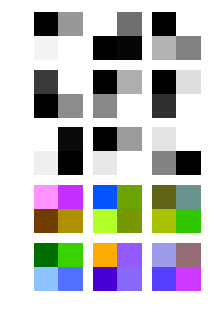

In [265]:
plt.figure(figsize=(3, 5))
for i in range(nfilters):
    plt.subplot(5, 3, i+1)
    plt.axis('off')
    ww0 = np.dot(w1w[:,:,0,i], w1h[:,:,0,i])
    ww1 = np.dot(w1w[:,:,1,i], w1h[:,:,1,i])
    ww2 = np.dot(w1w[:,:,2,i], w1h[:,:,2,i])
    #plt.imshow(cv2.cvtColor(w1[:,:,:,i], cv2.COLOR_YUV2RGB), interpolation='nearest')
    plt.imshow(ww0, interpolation='nearest', cmap='gray')
    plt.subplot(5, 3, i+1+3)
    plt.axis('off')
    plt.imshow(ww1, interpolation='nearest', cmap='gray')
    plt.subplot(5, 3, i+1+3+3)
    plt.axis('off')
    plt.imshow(ww2, interpolation='nearest', cmap='gray')
    plt.subplot(5, 3, i+1+3+3+3)
    plt.axis('off')
    ww = np.vstack([[ww0], [ww1], [ww2]]).T
    print w0.shape, ww.shape
    plt.imshow(cv2.cvtColor((ww*128.0 + 128.0).astype(np.uint8), cv2.COLOR_YUV2RGB), interpolation='nearest')
    plt.subplot(5, 3, i+1+3+3+3+3)
    plt.axis('off')
    plt.imshow(cv2.cvtColor((-ww*128.0 + 128.0).astype(np.uint8), cv2.COLOR_YUV2RGB), interpolation='nearest')


In [266]:
logits = classify(X_validation, w1w, w1h, b1, w2, b2)
with tf.Session() as sess:
    l = sess.run(tf.nn.softmax(logits))

(6, 270, 640, 3)


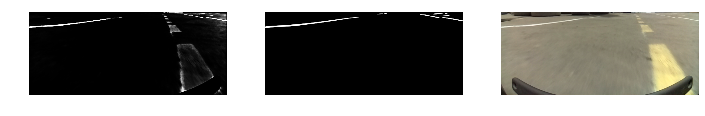

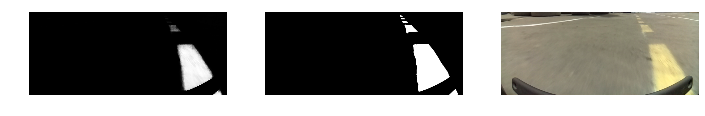

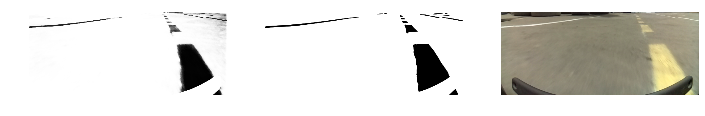

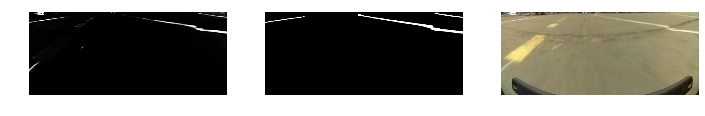

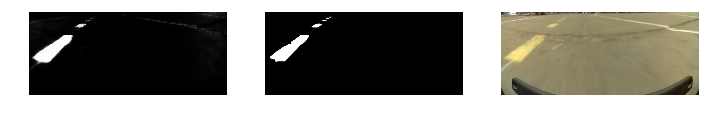

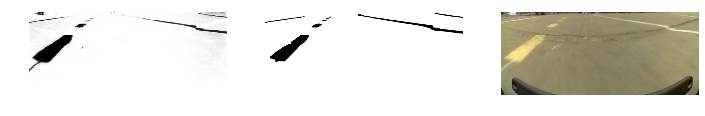

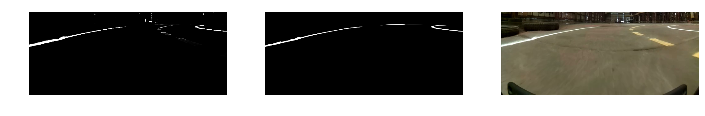

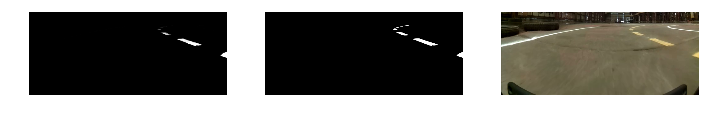

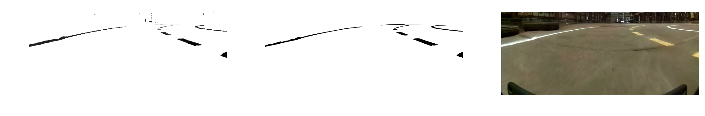

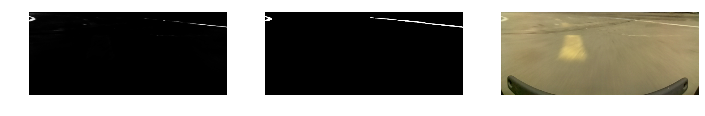

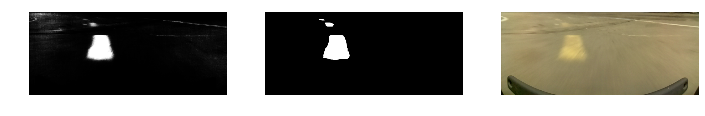

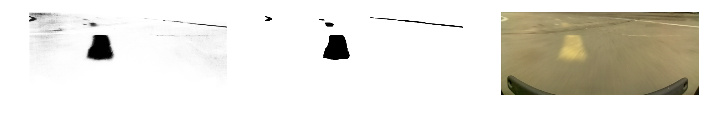

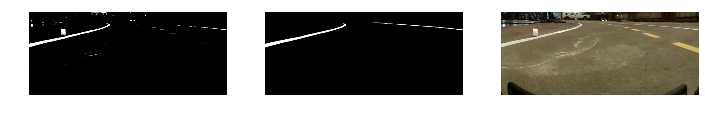

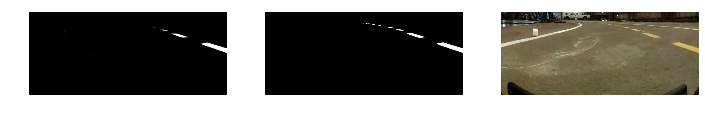

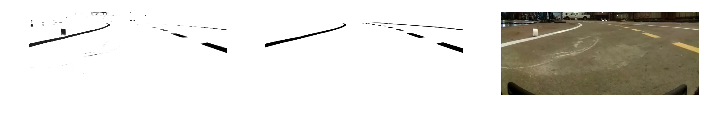

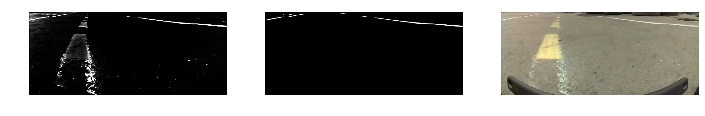

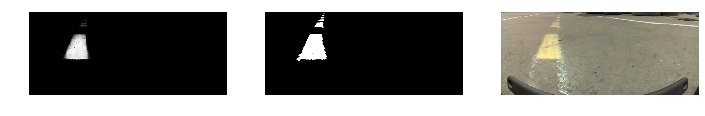

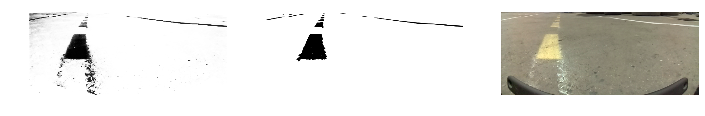

In [267]:
print l.shape
for j in range(len(X_validation)):
    for i in range(3):
        plt.figure(figsize=(12,3))
        plt.subplot(1, 3, 1)
        plt.axis('off')
        plt.imshow(l[j, :, :, i], 'gray')
        plt.subplot(1, 3, 2)
        plt.axis('off')
        plt.imshow(y_validation[j, :, :, i], 'gray')
        plt.subplot(1, 3, 3)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(np.uint8(X_validation[j, :, :] * 128.0 + 128.0), cv2.COLOR_YUV2RGB))
        plt.show()


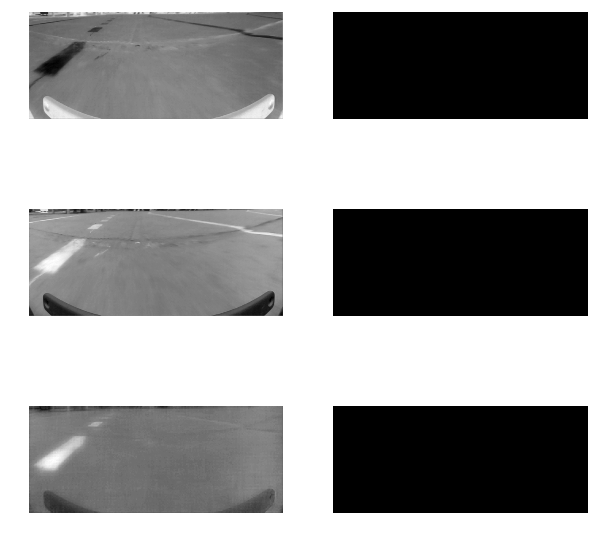

In [268]:
from scipy.signal import convolve2d

plt.figure(figsize=(10, 10))
for i in range(3):
    ww0 = np.dot(w1w[:,:,0,i], w1h[:,:,0,i])
    ww1 = np.dot(w1w[:,:,1,i], w1h[:,:,1,i])
    ww2 = np.dot(w1w[:,:,2,i], w1h[:,:,2,i])
    c = (convolve2d(X_validation[1,:,:,0], ww0)
         + convolve2d(X_validation[1,:,:,1], ww1)
         + convolve2d(X_validation[1,:,:,2], ww2)) + b1[i]
    plt.subplot(3, 2, 1+i*2)
    plt.axis('off')
    plt.imshow(np.maximum(0, c), 'gray')
    plt.subplot(3, 2, 2+i*2)
    plt.axis('off')
    plt.imshow(np.maximum(0, -c), 'gray')

In [271]:
w1

array([[ 0.02051607,  0.09962344,  0.01394751],
       [ 0.01102147,  0.05351888,  0.00749276],
       [ 0.01839955,  0.08934592,  0.01250863]], dtype=float32)

In [272]:
b1

array([ 3.62278986,  2.50416708,  1.86445129], dtype=float32)

In [269]:
w2

array([[[[ 0.52564728, -2.10164475,  0.51588511],
         [-0.91984779, -1.29533541,  1.06810284],
         [-1.14940095,  0.32929954,  0.40818915]]]], dtype=float32)

In [270]:
b2

array([ 1.46034801,  2.83041191, -0.08723684], dtype=float32)

In [ ]:
plt.imshow(cv2.cvtColor(train_img[1], cv2.COLOR_YUV2RGB))
plt.show()
plt.imshow(train_img[1][:, :, 1] < 110, 'gray')

In [ ]:
plt.imshow(train_img[1][:, :, 2] > 140, 'gray')

In [ ]:
plt.imshow(train_img[1][:, :, 0] > 140, 'gray')

In [ ]:
vid = cv2.VideoCapture("newtrack.h264")

idx = 0
while True:
    ok, img = vid.read()
    if not ok:
        break
    ytop = 275
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[ytop:]
    mask = (yuv[:, :, 1] < 110) & (yuv[:, :, 2] > 140) & (yuv[:, :, 0] > 150)
    coords = np.nonzero(mask)
    if len(coords[0]) > 4:
        p = np.polyfit(coords[0], coords[1], 1)
        if not np.any(np.isnan(p)):
            p = np.poly1d(p)
            y = np.linspace(480-ytop, 0, 50)
            for i in range(len(y) - 1):
                x0 = int(p(y[i]))
                x1 = int(p(y[i+1]))
                cv2.line(img, (x0, ytop+int(y[i])), (x1, ytop+int(y[i+1])), (0, 0, 255), 2)
    
    img[ytop:][mask, 1] = 255
    cv2.imshow('img', img)
    k = cv2.waitKey()
    if k == ord('q'):
        break
    
cv2.destroyAllWindows()
cv2.waitKey(1)

In [480]:
# 2480x2048 camera matrix -> 640x480 * 4
camera_matrix = np.float32([
    [  1.13826615e+03,  0.00000000e+00,  1.31095665e+03],
    [  0.00000000e+00,  1.13236467e+03,  9.29698331e+02],
    [  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

dist_coeffs = np.float32([-0.01789552, 0, 0, 0])

camera_matrix[:2] /= 4.
new_camera_matrix = np.copy(camera_matrix)
new_camera_matrix[:2, :2] /= 1.5  # adjust focal length for new camera

new_camera_matrix = np.float32([
        [-20, 0, 320],
        [0, 20, 480],
        [0, 0, 1]
    ])

new1_camera_matrix = np.float32([
        [150, 0, 320],
        [0, 150, 240],
        [0, 0, 1]
    ])

Rdown = cv2.Rodrigues(np.float32([-np.pi/2 - 0.075, 0, 0]))[0]
#Rdown = cv2.Rodrigues(np.float32([-0.075, 0, 0]))[0]
udm1, udm2 = cv2.fisheye.initUndistortRectifyMap(
    camera_matrix, dist_coeffs, Rdown, new_camera_matrix, (640, 480), cv2.CV_16SC2)
print udm1.shape, udm2.shape
# udm1, udm2 are reverse lookups: udm1[y, x] is the location of the pixel in the camera image
# which maps to x, y in the target image

# undistort_map is the forward lookup: undistort_map[y, x] contains the virtual pinhole camera
# coordinate of the real fisheye camera pixel x, y
undistort_map = cv2.fisheye.undistortPoints(
    np.mgrid[:640, :480].T.astype(np.float32),
    camera_matrix, dist_coeffs)

(480, 640, 2) (480, 640)


[-2.44011569 -0.09298677]


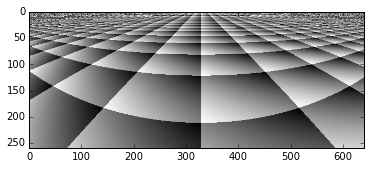

In [505]:
print undistort_map[220, 0]
udplane = np.dot(np.concatenate([undistort_map, np.ones((480, 640, 1))], axis=2), Rdown.T)[220:]

udplane[:, :, 0] /= udplane[:, :, 2]
udplane[:, :, 1] /= udplane[:, :, 2]
#udplane[:, :, :2] *= 10
plt.imshow((udplane[:, :, 0]%1) + (udplane[:, :, 1]%1), 'gray')

In [653]:
xycoords.shape

(260, 640, 2)

In [510]:
track = np.frombuffer(open("trackdata.f32").read(), np.float32)
track = track.reshape((4, len(track)/4))
# starting point is at 30, so rotate the track points so that it's in the front
# and also close the loop (repeat point 30 at the end)
track = np.hstack([track[:, 30:-1], track[:, 0:31]])
trackx = track[:2]
trackdx = track[2:4]
leftline = trackx + 20 * np.dot([[0, -1], [1, 0]], trackdx)
rightline = trackx + 20 * np.dot([[0, 1], [-1, 0]], trackdx)
trackx = np.vstack([trackx, np.zeros(track.shape[1]), np.ones(track.shape[1])])
leftline = np.vstack([leftline, np.zeros(track.shape[1]), np.ones(track.shape[1])])
rightline = np.vstack([rightline, np.zeros(track.shape[1]), np.ones(track.shape[1])])

def draw_track(img, P):
    # draw the track onto img using projection P
    # the track is represented as x, y, 0, 1 coordinates
    N = trackx.shape[1]
    trackproj = np.dot(P, trackx)
    trackproj[:2] /= trackproj[3]
    for i in range(0, N-1, 2):
        cv2.line(img,
                 (int(trackproj[0, i]), int(trackproj[1, i])),
                 (int(trackproj[0, i+1]), int(trackproj[1, i+1])),
                 (0, 0, 0), 3)
        cv2.line(img,
                 (int(trackproj[0, i]), int(trackproj[1, i])),
                 (int(trackproj[0, i+1]), int(trackproj[1, i+1])),
                 (0, 255, 255), 1)
    trackproj = np.dot(P, leftline)
    trackproj[:2] /= trackproj[3]
    for i in range(0, N-1):
        cv2.line(img,
                 (int(trackproj[0, i]), int(trackproj[1, i])),
                 (int(trackproj[0, i+1]), int(trackproj[1, i+1])),
                 (255, 255, 255), 1)
    trackproj = np.dot(P, rightline)
    trackproj[:2] /= trackproj[3]
    for i in range(0, N-1):
        cv2.line(img,
                 (int(trackproj[0, i]), int(trackproj[1, i])),
                 (int(trackproj[0, i+1]), int(trackproj[1, i+1])),
                 (255, 255, 255), 1)


In [654]:
track_distmap = cv2.imread("distmap.png")

viz_distmap = np.uint8(np.minimum(255, np.float32(track_distmap - 2)*10))
# birdseye = cv2.resize(cv2.imread("trackbirdseye.png"), (320, 512))

h = 3
s = 5

#xcoords = np.clip(np.int32(udplane[:, :, 0]*s + 200), 0, 255)
#ycoords = np.clip(np.int32(udplane[:, :, 1]*s + 185), 0, 511)
#plt.imshow(track_distmap[(ycoords, xcoords)], 'gray')
#xcoords = np.clip(np.int32(udplane[:, :, 0]*s + 200), 0, 255)
#ycoords = np.clip(np.int32(udplane[:, :, 1]*s + 185), 0, 511)

# fly over the distance map for fun
vidout = cv2.VideoWriter("distmapfly.h264", cv2.VideoWriter_fourcc(
      'X', '2', '6', '4'), 30, (640, xycoords.shape[0]), True)

for s in np.linspace(0, track.shape[1] - 1, 30*20)[:-1]:
    # we want -z to = dx
    # and x to point to y cross z
    si = int(s)
    st = s - si
    T = st*track[:, si+1] + (1-st)*track[:, si]
    T[2:4] /= np.linalg.norm(T[2:4])  # renormalize the track normal
    dx = np.array([-T[3], T[2]])
    dy = -T[2:4]
    T[:2] += 10*np.sin(s * 0.3) * dx    
    Rtrack = np.float32(np.vstack([-dx, dy]))
    Rphi = np.dot(cv2.Rodrigues(np.array([0, 0, 0.0]))[0][:2, :2], Rtrack.T)
    xycoords = np.float32(np.dot(udplane[:, :, :2], Rphi.T)*h + T[:2])
    #plt.figure(figsize=(12, 6))
    render = cv2.remap(viz_distmap, xycoords, None, cv2.INTER_LINEAR, borderValue=255)
    #plt.imshow(, 'gray')
    vidout.write(render)
    cv2.imshow('t', render)
    if cv2.waitKey(10) == ord('q'):
        break

del vidout
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [660]:
# set up a simple particle filter
# generate initial particles around start line

# make a resampler
# probability of state (s, e_y, psi):
#  - match yellow centerline on screen with projection
#  - use back of centerline marker tracking to propose a velocity distribution

def draw_particles(img, P, particles):
    s, ey, psi = particles
    s = np.mod(s, track.shape[1] - 1)
    N = len(s)
    si = np.int32(s)  # track point index (+1 hack to handle negatives)
    st = s - si  # fractional
    ts0 = track[:, si]
    ts1 = track[:, si+1]
    ts = st*ts1 + (1-st)*ts0  # interpolate along s
    ts[2:4] /= np.linalg.norm(ts[2:4], axis=0)  # renormalize the track normal
    dy = np.dot([[0, 1], [-1, 0]], ts[2:4])
    xy = np.vstack([ts[:2] + ey*dy, np.zeros(N), np.ones(N)])

    xyproj = np.dot(P, xy)
    xyproj = (xyproj[:2] / xyproj[3]).astype(np.int32)
    #xyproj = xyproj[:, ((xyproj[:,0] >= 0) & (xyproj[:,0] < 640) &
    #                    (xyproj[:,1] >= 0) & (xyproj[:,1] < 480))]
    img[(xyproj[1]), (xyproj[0]), :3] = 0
    img[(xyproj[1]), (xyproj[0]), 2:3] = 255


def particle_weight(particles, y):
    # for each particle we can find the local frame
    # y is all screen pixels which seem to be lane lines
    s, ey, psi = particles
    s = np.mod(s, track.shape[1] - 1)
    N = len(s)
    si = np.int32(s)  # track point index (+1 hack to handle negatives)
    st = s - si  # fractional
    ts0 = track[:, si]
    ts1 = track[:, si+1]
    ts = st*ts1 + (1-st)*ts0  # interpolate along s
    ts[2:4] /= np.linalg.norm(ts[2:4], axis=0)  # renormalize the track normal
    dy = np.dot([[0, 1], [-1, 0]], ts[2:4])
    xy = np.vstack([ts[:2] + ey*dy, np.zeros(N), np.ones(N)])
    
    ''' project each lane line point on the screen
    for a given particle, use something like
    planepixels = udplane[pixels]
    Rphi = cv2.Rodrigues(np.array([0, 0, psi]))[0][:2, :2]
    xycoords = np.float32(np.dot(planepixels[:, :2], Rphi.T)*s + xy)
    '''


In [661]:
# array([ 200.40493022,   97.33224579,  143.97553018])

out = cv2.VideoWriter("neato.h264", cv2.VideoWriter_fourcc(
      'X', '2', '6', '4'), 30, (640, 480), True)

framectr = 0

# linear white line / yellow line / background classifier
yuvw1 = np.array([
    [  7.64430666,   4.79871893,  -6.13509226],
    [  6.2450037 , -19.7711277 ,   5.95682621],
    [ -4.67799187,  14.61457253,  -4.42752457]], dtype=np.float32)

yuvb1 = 128 * (-np.dot([1, 1, 1], yuvw1) +
               np.array([-2.20822358, -6.71973562,  4.39618778], dtype=np.float32))

particles = (np.random.randn(1000, 3) * np.array([5, 10, 0.5]) + np.array([10, 0, 0])).T

f = open("hmm34")
while True:
    fsize = 12 + 640*480 + 320*240*2
    frame = np.frombuffer(f.read(fsize), np.uint8)
    tstamp = np.frombuffer(np.getbuffer(frame[:8]), np.uint32)
    
    controls = np.frombuffer(np.getbuffer(frame[8:12]), np.uint16)
    controls = np.float32(controls) / 204.8 - 3.0

    if len(frame) < fsize:
        break
    y = frame[12:12+640*480]
    u = frame[12+640*480:12+640*480+320*240]
    v = frame[12+640*480+320*240:]
    img = cv2.cvtColor(frame[12:].reshape((-1, 640)), cv2.COLOR_YUV420P2RGB)
    # if (framectr % 27) == 20:
    #     cv2.imwrite("training/f%04d.png" % framectr, img)
    framectr += 1
    
    ytop = 220
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[ytop:]
    pixelclass = np.argmax(np.dot(yuv, yuvw1) + yuvb1, axis=2)
    mask = pixelclass == 1
    
    # img[y.reshape((480,640)) > 240, :] = 0
    
    # find bottom-most pixel of each connected component (very cheap)
    if True:
        _, contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img[ytop:], contours, -1, (255, 0, 0), 3)
        for c in contours:
            if c.shape[0] < 10:
                continue
            bottom = np.argmax(c[:,0,1])
            cv2.circle(img[ytop:], (c[bottom, 0, 0], c[bottom, 0, 1]), 10, (255, 255, 0), 2)

        coords = np.nonzero(mask)
        if False and len(coords[0]) > 4:  # disable polyfit
            p = np.polyfit(coords[0], coords[1], 1)
            if not np.any(np.isnan(p)):
                p = np.poly1d(p)
                y = np.linspace(480-ytop, 0, 50)
                for i in range(len(y) - 1):
                    x0 = int(p(y[i]))
                    x1 = int(p(y[i+1]))
                    cv2.line(img, (x0, ytop+int(y[i])), (x1, ytop+int(y[i+1])), (0, 0, 255), 2)

    img[ytop:][mask, 1] = 255
    img[ytop:][mask, 2] = 255
    
    img[ytop:][pixelclass == 0, 0] = 255
    img[ytop:][pixelclass == 0, 1] = 255
    img[ytop:][pixelclass == 0, 2] = 0
    
    birdseye = cv2.remap(img, udm1, udm2, cv2.INTER_LINEAR)  #, borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))
    #img = cv2.fisheye.undistortImage(img, camera_matrix, D=np.zeros(4), Knew=new_camera_matrix)
    outframe = np.copy(img)
    outframe[:120,:160,:] = cv2.resize(birdseye, (160, 120), cv2.INTER_LINEAR)
    #outframe[:120,:160,:] = cv2.resize(img, (160, 120), cv2.INTER_LINEAR)
    cv2.line(outframe, (0, ytop), (640, ytop), (255, 255, 255), 1)
    
    controls[1] = -controls[1] + 6500/32768.0  # steering is backwards and has a trim value of ~6500
    controls = np.int16(300*controls) + 320
    cv2.line(outframe, (320, 465), (controls[0], 465), (0, 0, 0), 5)
    cv2.line(outframe, (320, 465), (controls[0], 465), (255, 255, 255), 3)
    cv2.line(outframe, (controls[0], 460), (controls[0], 470), (0, 0, 0), 5)
    cv2.line(outframe, (controls[0], 460), (controls[0], 470), (255, 255, 255), 3)
    cv2.line(outframe, (320, 475), (controls[1], 475), (0, 0, 0), 5)
    cv2.line(outframe, (320, 475), (controls[1], 475), (255, 128, 255), 3)
    cv2.line(outframe, (controls[1], 470), (controls[1], 480), (0, 0, 0), 5)
    cv2.line(outframe, (controls[1], 470), (controls[1], 480), (255, 128, 255), 3)
    
    timestring = time.strftime("%Y-%m-%d %H:%M:%S.", time.localtime(tstamp[0]))
    timestring += "%03d" % (tstamp[1] // 1000)
    cv2.putText(outframe, timestring, (0, 479), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)
    cv2.putText(outframe, timestring, (0, 479), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    trackP = np.float32([[0.5, 0, 0, 640-129], [0, 0.5, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])
    draw_track(outframe, trackP)
    draw_particles(outframe, trackP, particles)

    out.write(outframe)
    cv2.imshow('f', outframe)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

del out

cv2.destroyAllWindows()
cv2.waitKey(1)


-1

In [426]:
np.mgrid[:640, :480].T.shape


(480, 640, 2)

In [340]:
rate = 0.1

import tensorflow as tf

input_img = tf.placeholder(tf.float32, (None, 270, 640, 3), name="input_img")  # YUV
input_labels = tf.placeholder(tf.float32, (None, 270, 640, 3), name="input_labels")  # white line / yellow line / neither

f1_W = tf.Variable(tf.truncated_normal((3, 6), mean=0, stddev=0.1))
f1_b = tf.Variable(np.zeros(6).astype(np.float32))

def classify(input_img, f1_W, f1_b):
    # we have 6 feature detectors for 3 categories, 2 each
    features = tf.tensordot(input_img, f1_W, axes=[[3], [0]]) + f1_b
    # so take the max of each
    logits = tf.reduce_max(tf.reshape(features, [-1, 270, 640, 3, 2]), axis=4)
    print logits.shape
    return logits

# output shape is NxWxHx3
# now i want per-pixel cross entropy
logits = classify(input_img, f1_W, f1_b)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    logits=tf.reshape(logits, [-1, 3]),
    labels=tf.reshape(input_labels, [-1, 3]))

loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

def evaluate(X_data, y_data):
    BATCH_SIZE=100
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(loss_operation, feed_dict={input_img: batch_x, input_labels: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

(?, 270, 640, 3)


In [294]:
np.tensordot(np.ones((10, 5, 5, 3)), np.ones((3, 3)), axes=[[3], [0]]).shape

(10, 5, 5, 3)

In [341]:
X_train, y_train = shuffle(np.array(train_img), np.array(train_lab))
X_validation = X_train[:6]
y_validation = y_train[:6]
X_train = X_train[6:]
y_train = y_train[6:]

print(X_train.shape, y_train.shape, X_validation.shape)


BATCH_SIZE = 100
EPOCHS = 1000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss, _ = sess.run([loss_operation, training_operation], feed_dict={
                    input_img: batch_x, input_labels: batch_y})
            print("batch %d loss" % offset, loss)
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        if (i % 20) == 0:
            w1, b1 = f1_W.eval(sess), f1_b.eval(sess)
            print("Model saved into w1, b1")
    w1, b1 = f1_W.eval(sess), f1_b.eval(sess)
    print("Model saved into w1, b1")

((36, 270, 640, 3), (36, 270, 640, 3), (6, 270, 640, 3))
Training...
('batch 0 loss', 1.1161153)
EPOCH 1 ...
Validation Accuracy = 0.948
Model saved into w1, b1
('batch 0 loss', 0.95294917)
EPOCH 2 ...
Validation Accuracy = 0.823
('batch 0 loss', 0.82835954)
EPOCH 3 ...
Validation Accuracy = 0.714
('batch 0 loss', 0.72117728)
EPOCH 4 ...
Validation Accuracy = 0.618
('batch 0 loss', 0.63041592)
EPOCH 5 ...
Validation Accuracy = 0.539
('batch 0 loss', 0.5566746)
EPOCH 6 ...
Validation Accuracy = 0.472
('batch 0 loss', 0.4923071)
EPOCH 7 ...
Validation Accuracy = 0.416
('batch 0 loss', 0.440247)
EPOCH 8 ...
Validation Accuracy = 0.373
('batch 0 loss', 0.40125772)
EPOCH 9 ...
Validation Accuracy = 0.338
('batch 0 loss', 0.36984971)
EPOCH 10 ...
Validation Accuracy = 0.310
('batch 0 loss', 0.34435326)
EPOCH 11 ...
Validation Accuracy = 0.287
('batch 0 loss', 0.32469982)
EPOCH 12 ...
Validation Accuracy = 0.270
('batch 0 loss', 0.31010079)
EPOCH 13 ...
Validation Accuracy = 0.256
('batch 0 l

KeyboardInterrupt: 

In [342]:
logits = classify(X_validation, w1, b1)
with tf.Session() as sess:
    l = sess.run(tf.nn.softmax(logits))

(6, 270, 640, 3)


(6, 270, 640, 3)


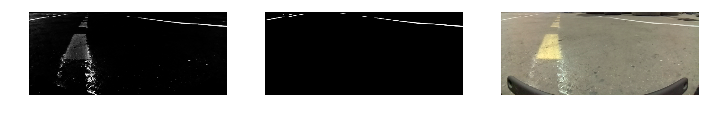

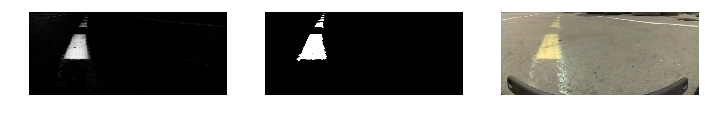

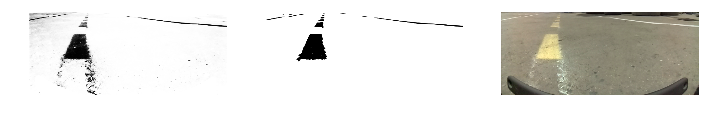

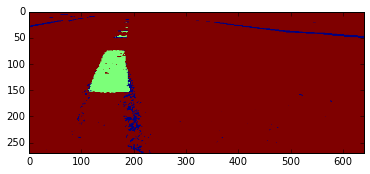

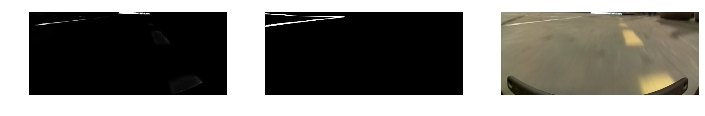

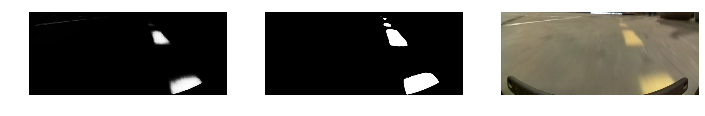

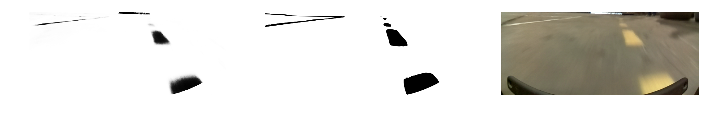

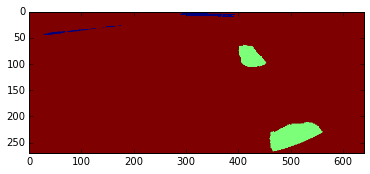

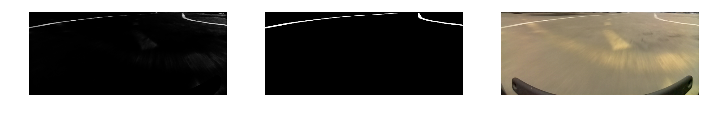

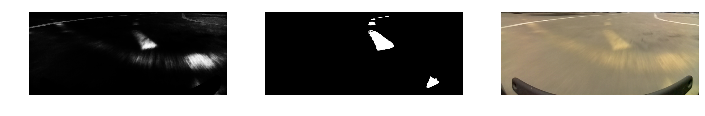

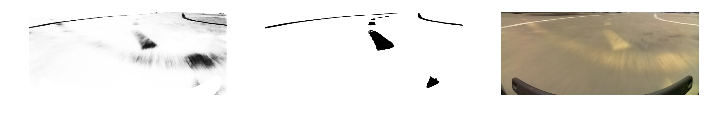

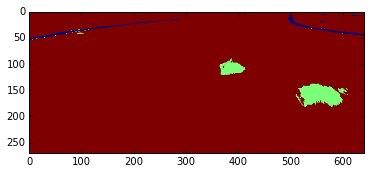

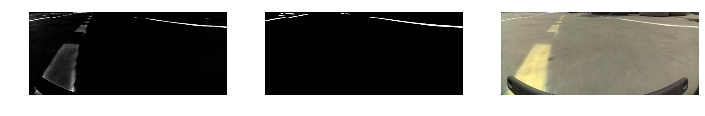

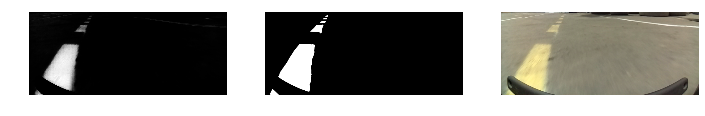

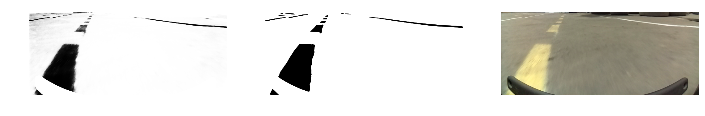

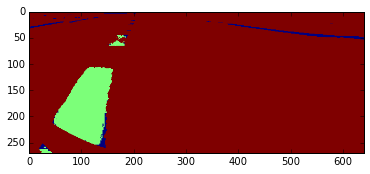

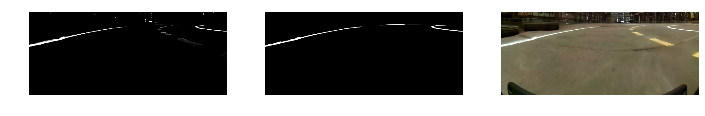

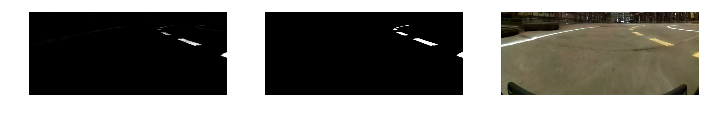

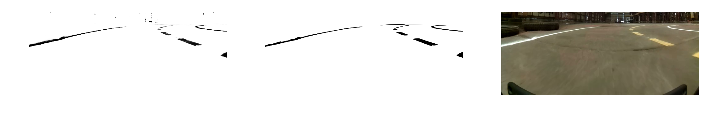

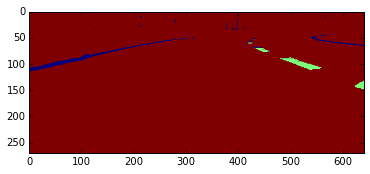

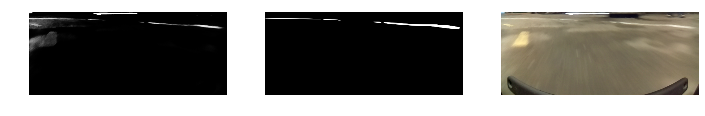

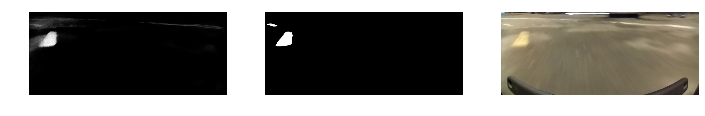

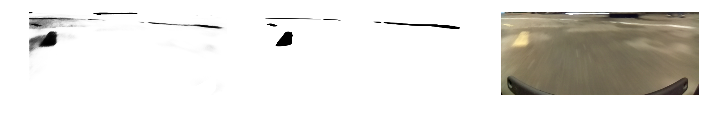

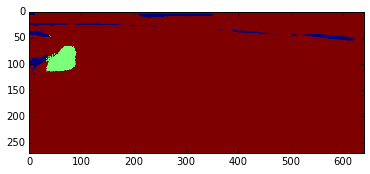

In [343]:
print l.shape
for j in range(len(X_validation)):
    for i in range(3):
        plt.figure(figsize=(12,3))
        plt.subplot(1, 3, 1)
        plt.axis('off')
        plt.imshow(l[j, :, :, i], 'gray')
        plt.subplot(1, 3, 2)
        plt.axis('off')
        plt.imshow(y_validation[j, :, :, i], 'gray')
        plt.subplot(1, 3, 3)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(np.uint8(X_validation[j, :, :] * 128.0 + 128.0), cv2.COLOR_YUV2RGB))
        plt.show()
    plt.imshow(np.argmax(l[j], axis=2))
    plt.show()

In [345]:
w1.T

array([[  1.58848810e+00,   2.14362621e+00,  -2.26762247e+00],
       [  8.59195423e+00,   4.12409210e+00,  -4.25355577e+00],
       [  1.48291016e+00,   1.89061403e+00,  -1.98078763e+00],
       [  5.47078180e+00,  -1.09828901e+01,   1.00288229e+01],
       [ -1.01818991e+00,   1.04233050e+00,  -7.33943164e-01],
       [ -7.47770739e+00,  -1.05457380e-02,   4.09852177e-01]], dtype=float32)

In [346]:
b1

array([-2.24789071, -2.11784983, -2.18785834, -4.11959934,  1.54532957,
        4.11049414], dtype=float32)

In [309]:
np.round(w1 * (128 / 19.7711277)).astype(np.int8)

array([[  49,   31,  -40],
       [  40, -128,   39],
       [ -30,   95,  -29]], dtype=int8)

In [310]:
np.round(b1 * (128 / 19.7711277)).astype(np.int8)

array([-14, -44,  28], dtype=int8)

In [320]:
np.dot((np.array([170, 100, 150]) - 128.0) / 128.0, w1) + b1

array([-1.87005987,  1.69165786,  0.31907412])

In [324]:
np.dot(np.array([170, 100, 150]), w1) + 128.0 * (np.dot([1, 1, 1], -w1) + b1)

array([-239.36766338,  216.53220654,   40.84148693])

In [325]:
128.0 * (np.dot([1, 1, 1], -w1) + b1)

array([-1461.7013855 ,  -814.32312012,  1152.25323486])

In [326]:
w1

array([[  7.64430666,   4.79871893,  -6.13509226],
       [  6.2450037 , -19.7711277 ,   5.95682621],
       [ -4.67799187,  14.61457253,  -4.42752457]], dtype=float32)

In [406]:
np.mod(-3.0, 3)

0.0